In [1]:
import numpy as np

# Given data
np.random.seed(1)
points = np.random.rand(6, 2)
data = points * 10

# Function to compute distance between two points
def compute_distance(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

# Compute the distance matrix
distance_matrix = np.zeros((len(data), len(data)))
for i in range(len(data)):
    for j in range(len(data)):
        distance_matrix[i, j] = compute_distance(data[i], data[j])

distance_matrix


array([[0.        , 5.90363632, 6.83673944, 4.40112356, 1.82634369,
        0.35172153],
       [5.90363632, 0.        , 2.56127322, 1.91099309, 4.61799134,
        5.67653559],
       [6.83673944, 2.56127322, 0.        , 2.56285075, 5.11711365,
        6.52480323],
       [4.40112356, 1.91099309, 2.56285075, 0.        , 2.85764224,
        4.11857344],
       [1.82634369, 4.61799134, 5.11711365, 2.85764224, 0.        ,
        1.48110574],
       [0.35172153, 5.67653559, 6.52480323, 4.11857344, 1.48110574,
        0.        ]])

In [7]:

def compute_distance_from_point_to_set(point, points_set, data):
    """Compute the average distance from a single point to a set of points."""
    return np.mean([compute_distance(point, data[p]) for p in points_set])

def group_points(distance_matrix, initial_threshold, a, b):
    """
    Group points based on the given threshold formula.
    
    Parameters:
    - distance_matrix: pairwise distance between points
    - initial_threshold: initial value of the threshold
    - a, b: constants in the threshold formula
    
    Returns:
    - List of groups. Each group is represented as a list of point indices.
    """
    n = len(distance_matrix)
    ungrouped_points = set(range(n))  # All points are initially ungrouped
    groups = []
    
    while ungrouped_points:
        current_group = [ungrouped_points.pop()]  # Start a new group with a random point
        group_center = np.mean([data[p] for p in current_group], axis=0)
        points_added = True
        
        while points_added:  # Try adding points to the current group
            points_added = False
            distances_to_group = {point: compute_distance_from_point_to_set(group_center, current_group, data) for point in ungrouped_points}
            # Sort points by distance to the group center
            sorted_points = sorted(distances_to_group.keys(), key=lambda p: distances_to_group[p])
            
            for point in sorted_points:
                # Compute threshold for the current group
                num_points = len(current_group)
                avg_distance = sum(distance_matrix[p1][p2] for p1 in current_group for p2 in current_group) / (num_points * num_points)
                threshold = initial_threshold - a * (num_points - 1) - b * avg_distance
                
                if distances_to_group[point] <= threshold:
                    current_group.append(point)
                    ungrouped_points.remove(point)
                    # Update the group center to the mean of the current group
                    group_center = np.mean([data[p] for p in current_group], axis=0)
                    points_added = True
                    break  # Try to add another point to the current group
        
        groups.append(current_group)
    
    return groups

# Test the function with sample parameters
groups = group_points(distance_matrix, initial_threshold=3, a=0.5, b=0.5)
groups


[[0, 1], [2, 3, 4], [5]]

In [11]:
from itertools import permutations
from scipy.spatial import distance

def tsp_bruteforce(distance_matrix):
    n = len(distance_matrix)
    min_path = None
    min_distance = float('inf')

    # Check all possible permutations of the points (excluding the starting point)
    for perm in permutations(range(1, n)):
        current_distance = distance_matrix[0][perm[0]] + distance_matrix[perm[-1]][0]  # starting and ending at point 0
        for i in range(len(perm) - 1):
            current_distance += distance_matrix[perm[i]][perm[i+1]]
        if current_distance < min_distance:
            min_distance = current_distance
            min_path = (0,) + perm

    return min_path, min_distance

tsp_path, tsp_distance = tsp_bruteforce(distance_matrix)
tsp_path, tsp_distance


((0, 1, 2, 3, 4, 5), 15.718229796858594)

In [3]:
class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n
        
    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]
    
    def union(self, x, y):
        rootX = self.find(x)
        rootY = self.find(y)
        
        if rootX != rootY:
            if self.rank[rootX] > self.rank[rootY]:
                self.parent[rootY] = rootX
            else:
                self.parent[rootX] = rootY
                if self.rank[rootX] == self.rank[rootY]:
                    self.rank[rootY] += 1

def group_points_union_find(distance_matrix, initial_threshold, a, b):
    n = len(distance_matrix)
    uf = UnionFind(n)
    
    for i in range(n):
        for j in range(i+1, n):
            num_points = 2  # Start with the two points being considered
            avg_distance = distance_matrix[i][j]
            threshold = initial_threshold - a * (num_points - 1) - b * avg_distance
            
            if distance_matrix[i][j] <= threshold:
                uf.union(i, j)
    
    # Extract distinct sets/groups from the UnionFind structure
    groups_dict = {}
    for i in range(n):
        root = uf.find(i)
        if root not in groups_dict:
            groups_dict[root] = []
        groups_dict[root].append(i)
    
    return list(groups_dict.values())

# Test the function with sample parameters
groups_uf = group_points_union_find(distance_matrix, initial_threshold=3, a=0.5, b=0.5)
groups_uf


[[0, 4, 5], [1], [2], [3]]

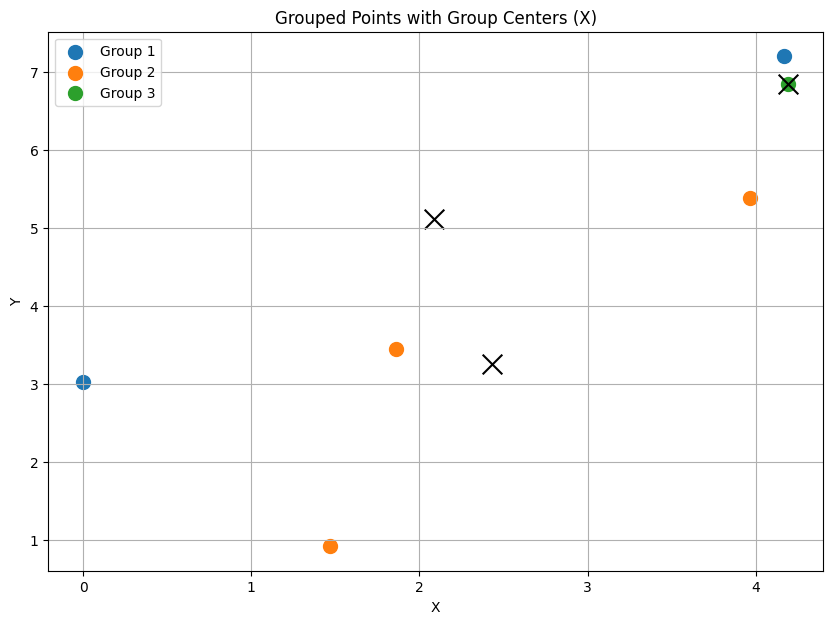

In [9]:
import matplotlib.pyplot as plt

def visualize_groups(data, groups):
    plt.figure(figsize=(10, 7))
    
    # Plot each group with a distinct color
    for group in groups:
        group_data = [data[i] for i in group]
        group_data = np.array(group_data)
        plt.scatter(group_data[:, 0], group_data[:, 1], s=100, label=f'Group {groups.index(group)+1}')
        
        # Plot the mean of the group
        group_mean = np.mean(group_data, axis=0)
        plt.scatter(group_mean[0], group_mean[1], s=200, marker='x', color='black')
    
    plt.title('Grouped Points with Group Centers (X)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_groups(data, groups)


In [13]:
def group_points_tsp_order(distance_matrix, initial_threshold, a, b, tsp_order):
    """
    Group points based on the given threshold formula and TSP order.
    
    Parameters:
    - distance_matrix: pairwise distance between points
    - initial_threshold: initial value of the threshold
    - a, b: constants in the threshold formula
    - tsp_order: order of points as determined by TSP
    
    Returns:
    - List of groups. Each group is represented as a list of point indices.
    """
    n = len(distance_matrix)
    ungrouped_points = set(tsp_order)  # All points are initially ungrouped, but follow TSP order
    groups = []
    
    while ungrouped_points:
        current_group = [ungrouped_points.pop()]  # Start a new group with the next point in TSP order
        group_center = np.mean([data[p] for p in current_group], axis=0)
        points_added = True
        
        while points_added:  # Try adding points to the current group
            points_added = False
            
            # Extract distances from distance matrix and sort by distance
            distances_to_group = [(point, distance_matrix[current_group[-1]][point]) for point in ungrouped_points]
            sorted_points = [point for point, _ in sorted(distances_to_group, key=lambda x: x[1])]
            
            for point in sorted_points:
                # Compute threshold for the current group
                num_points = len(current_group)
                avg_distance = sum(distance_matrix[p1][p2] for p1 in current_group for p2 in current_group) / (num_points * num_points)
                threshold = initial_threshold - a * (num_points - 1) - b * avg_distance
                
                if distance_matrix[current_group[-1]][point] <= threshold:
                    current_group.append(point)
                    ungrouped_points.remove(point)
                    # Update the group center to the mean of the current group
                    group_center = np.mean([data[p] for p in current_group], axis=0)
                    points_added = True
                    break  # Try to add another point to the current group
        
        groups.append(current_group)
    
    return groups

# Test the function with sample parameters and TSP order
groups_tsp_order = group_points_tsp_order(distance_matrix, initial_threshold=3, a=0.5, b=0.5, tsp_order=tsp_path[:-1])  # Exclude the last point in tsp_path since it's a repeat of the starting point
groups_tsp_order


[[0, 4], [1, 3], [2]]

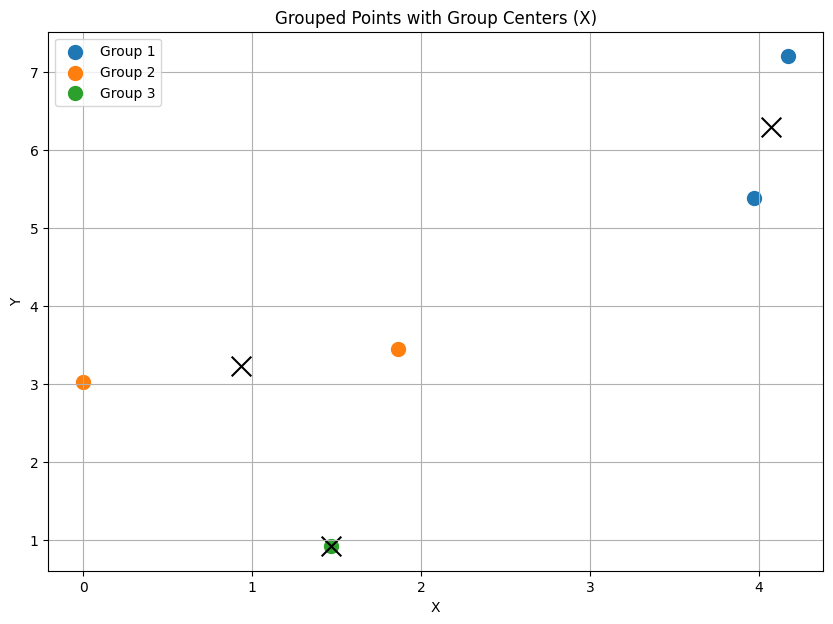

In [14]:
visualize_groups(data, groups_tsp_order
)